# Notebook to generate AABC cumulative recruitment stats and historical HCA stats by key demographic variables (draft)

## TO DO add same plots filtered down to those who actually came in ... also merge HCA REDCap race with phone arm to compare demographic breakdown of those who re-enrolled vs. not.  Also check demographics of participants who didn't pass screening.  


In [1]:
#load some libraries
import pandas as pd
import seaborn as sns
from ccf.box import LifespanBox
import yaml
from functions import *
from config import *
import numpy as np
import matplotlib.pyplot as plt



In [2]:
#load HCA inventory 
config = LoadSettings()
secret=pd.read_csv(config['config_files']['secrets'])
box = LifespanBox(cache="./tmp")
pathp=box.downloadFile(config['hcainventory'])
ids=pd.read_csv(pathp)

In [3]:
#load AABC report
aabcarms = redjson(tok=secret.loc[secret.source=='aabcarms','api_key'].reset_index().drop(columns='index').api_key[0])
hcpa = redjson(tok=secret.loc[secret.source=='hcpa','api_key'].reset_index().drop(columns='index').api_key[0])
#just a report
aabcreport = redreport(tok=secret.loc[secret.source=='aabcarms','api_key'].reset_index().drop(columns='index').api_key[0],reportid='51031')

#download the inventory report from AABC for comparison
aabcinvent=getframe(struct=aabcreport,api_url=config['Redcap']['api_url10'])


HTTP Status: 200


In [4]:
#(pd.to_datetime(aabcinvent.v0_date)-today()).days
from datetime import date
aabcinvent['todaydate']=date.today()
aabcinvent['dayspassed']=(pd.to_datetime(aabcinvent.todaydate) - pd.to_datetime(aabcinvent.v0_date)).dt.days
#(pd.to_datetime(aabcinvent.v0_date)
aabcinvent.dayspassed
# - date.today()).days()

0      195.0
1        NaN
2      181.0
3        NaN
4      167.0
       ...  
209      NaN
210     24.0
211     19.0
212      3.0
213      NaN
Name: dayspassed, Length: 214, dtype: float64

In [5]:
#PREPARE DATA FOR PLOTS
forplot=aabcinvent.loc[aabcinvent.redcap_event_name.str.contains('register')][['v0_date','dayspassed','age','sex','racial','ethnic','site']]
forplot=forplot.sort_values('dayspassed')

#forplot['sexsum']=
S=pd.get_dummies(forplot.sex, prefix='sex')
#forplot['sexsum']=pd.to_numeric(forplot.sex, errors='coerce').cumsum()
forplot['malesum']=pd.to_numeric(S.sex_1, errors='coerce').cumsum()
forplot['femalesum']=pd.to_numeric(S.sex_2, errors='coerce').cumsum()

#1, Native American/Alaskan Native | 2, Asian | 3, Black or African American | 4, Native Hawaiian or Other Pacific Is | 5, White | 6, More than one race | 99, Unknown or Not reported
S2=pd.get_dummies(forplot.racial, prefix='race')
forplot['whitesum']=pd.to_numeric(S2.race_5, errors='coerce').cumsum()
#forplot['natpacsum']=pd.to_numeric(S2.race_4, errors='coerce').cumsum()
forplot['blacksum']=pd.to_numeric(S2.race_3, errors='coerce').cumsum()
forplot['asiansum']=pd.to_numeric(S2.race_2, errors='coerce').cumsum()
#forplot['natamersum']=pd.to_numeric(S2.race_1, errors='coerce').cumsum()
forplot['moret1sum']=pd.to_numeric(S2.race_6, errors='coerce').cumsum()
#forplot['nasum']=pd.to_numeric(S2.race_7, errors='coerce').cumsum()

#thnicity
S3=pd.get_dummies(forplot.ethnic, prefix='ethnicity')
forplot['hispanicsum']=pd.to_numeric(S3.ethnicity_1, errors='coerce').cumsum()
forplot['nonhispanicsum']=pd.to_numeric(S3.ethnicity_2, errors='coerce').cumsum()
forplot['unkhispsum']=pd.to_numeric(S3.ethnicity_3, errors='coerce').cumsum()



#sites
S4=pd.get_dummies(forplot.site, prefix='site')
forplot['wusum']=pd.to_numeric(S4.site_4, errors='coerce').cumsum()
forplot['umnsum']=pd.to_numeric(S4.site_3, errors='coerce').cumsum()
forplot['mghsum']=pd.to_numeric(S4.site_1, errors='coerce').cumsum()
#forplot['uclasum']=pd.to_numeric(S4.site_2, errors='coerce').cumsum()

forplot.age

##ages
bins= [20,40,60,80,100]
forplot['ages']=pd.to_numeric(forplot.age)
forplot['AgeGroup'] = pd.cut(forplot['ages'], bins=bins,right=False)# labels=labels,
S5=pd.get_dummies(forplot.AgeGroup, prefix='age')
forplot['age20sum']=pd.to_numeric(S5['age_[20, 40)'], errors='coerce').cumsum()
forplot['age40sum']=pd.to_numeric(S5['age_[40, 60)'], errors='coerce').cumsum()
forplot['age60sum']=pd.to_numeric(S5['age_[60, 80)'], errors='coerce').cumsum()
forplot['age80sum']=pd.to_numeric(S5['age_[80, 100)'],errors='coerce').cumsum()



Text(0, 0.5, 'Number of Subjects')

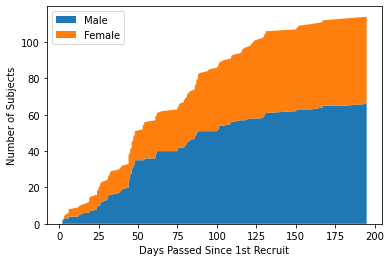

In [6]:
### create plot of AABC recruitment stats by SEX
# Create data
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.malesum) #[1,4,6,8,9]
y2=list(forplot.femalesum)#[2,2,7,10,12]

# Basic stacked area chart.
plt.stackplot(x,y1, y2, labels=['Male','Female'])
plt.legend(loc='upper left')
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects')

Text(0, 0.5, 'Number of Subjects')

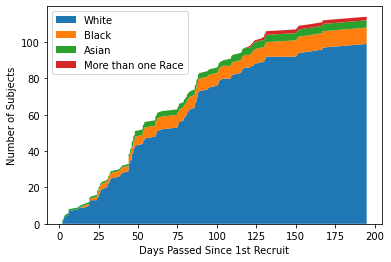

In [7]:
#BY RACE
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.whitesum) #[1,4,6,8,9]
y2=list(forplot.blacksum)#[2,2,7,10,12]
y3=list(forplot.asiansum)
y4=list(forplot.moret1sum)
# Basic stacked area chart.
plt.stackplot(x,y1, y2,y3,y4, labels=['White','Black','Asian','More than one Race'])
plt.legend(loc='upper left')
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects')

Text(0, 0.5, 'Number of Subjects')

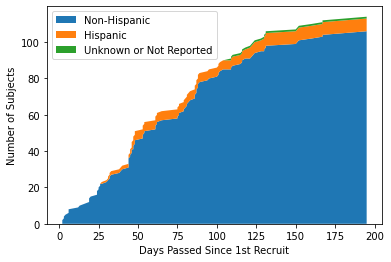

In [8]:
#BY ETHNICITY
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.nonhispanicsum) #[1,4,6,8,9]
y2=list(forplot.hispanicsum)#[2,2,7,10,12]
y3=list(forplot.unkhispsum)
# Basic stacked area chart.
plt.stackplot(x,y1, y2,y3, labels=['Non-Hispanic','Hispanic','Unknown or Not Reported'])
plt.legend(loc='upper left')
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects')

Text(0, 0.5, 'Number of Subjects')

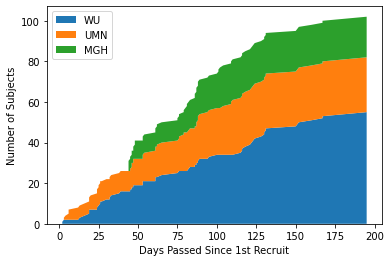

In [9]:
#By Site
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.wusum) #[1,4,6,8,9]
y2=list(forplot.umnsum)#[2,2,7,10,12]
y3=list(forplot.mghsum)
# Basic stacked area chart.
plt.stackplot(x,y1, y2,y3, labels=['WU','UMN','MGH'])
plt.legend(loc='upper left')
plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects')


Text(0, 0.5, 'Number of Subjects')

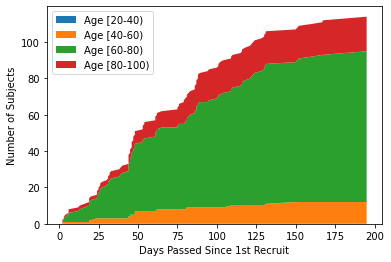

In [10]:
#By Age Bin
x=list(forplot.dayspassed) #range(1,6)
y1=list(forplot.age20sum) #[1,4,6,8,9]
y2=list(forplot.age40sum)#[2,2,7,10,12]
y3=list(forplot.age60sum)
y4=list(forplot.age80sum)
# Basic stacked area chart.
plt.stackplot(x,y1, y2,y3,y4, labels=['Age [20-40)','Age [40-60)','Age [60-80)','Age [80-100)'])
plt.legend(loc='upper left')

plt.xlabel('Days Passed Since 1st Recruit')
plt.ylabel('Number of Subjects')

In [11]:
#request or load AABC REDCAP API Key

In [12]:
#subset to v1 for recruitment stats
forstats=ids[['subject','redcap_event','event_age','site','M/F','race','ethnic_group','pedid']].loc[ids.redcap_event.isin(['V1','V2'])].sort_values('redcap_event').drop_duplicates(subset='subject',keep='first')


In [13]:
#bin ages
bins= [20,30,40,50,60,70,80,90,100,110]
forstats['AgeGroup'] = pd.cut(forstats['event_age'], bins=bins,right=False)# labels=labels,

## produce some UNIVARIATE HCA demographic stats

In [14]:
a=pd.DataFrame(forstats.groupby(['site']).count().pedid).rename(columns={'pedid':'count'})
a.to_csv('HCA_Site.csv')
a

,count
site,
MGH,292
UCLA,298
UMinn,307
WashU,318


In [15]:
b=pd.DataFrame(forstats.groupby(['AgeGroup']).count().pedid).rename(columns={'pedid':'count'})
b.to_csv('HCA_Age.csv')
b

,count
AgeGroup,
"[20, 30)",11
"[30, 40)",104
"[40, 50)",234
"[50, 60)",233
"[60, 70)",210
"[70, 80)",184
"[80, 90)",194
"[90, 100)",45
"[100, 110)",0


In [16]:
c=pd.DataFrame(forstats.groupby(['M/F']).count().pedid).rename(columns={'pedid':'count'})
c.to_csv('HCA_Sex.csv')
c

,count
M/F,
F,690
M,525


In [17]:
d=pd.DataFrame(forstats.groupby(['race']).count().pedid).rename(columns={'pedid':'count'})
d.to_csv('HCA_Race.csv')
d

,count
race,
American Indian/Alaska Native,3
Asian,77
Black or African American,167
Hawaiian or Pacific Islander,3
More than one race,46
Unknown or not reported,23
White,896


In [18]:
e=pd.DataFrame(forstats.groupby(['ethnic_group']).count().pedid).rename(columns={'pedid':'count'})
e.to_csv('HCA_Ethnicity.csv')
e

,count
ethnic_group,
Hispanic or Latino,139
Not Hispanic or Latino,1074
unknown or not reported,2


## HCA demographics by Age

In [ ]:
print('************  BY AGE  ********************')
print(forstats.groupby(['AgeGroup','site']).count().pedid)
pd.DataFrame(pd.crosstab(forstats['AgeGroup'], [forstats.site])).to_csv('HCA_Age_x_Site.csv',index=True)
print('*******************************************************')
print(forstats.groupby(['AgeGroup','M/F']).count().pedid)
pd.DataFrame(pd.crosstab(forstats['AgeGroup'], forstats['M/F'])).to_csv('HCA_Age_x_Sex.csv',index=True)
print('*******************************************************')
print(forstats.groupby(['AgeGroup','race']).count().pedid)
pd.DataFrame(pd.crosstab(forstats['AgeGroup'], [forstats.race])).to_csv('HCA_Age_x_Race.csv',index=True)
print('*******************************************************')
print(forstats.groupby(['AgeGroup','ethnic_group']).count().pedid)
pd.DataFrame(pd.crosstab(forstats['AgeGroup'], [forstats.ethnic_group])).to_csv('HCA_Age_x_Ethnicity.csv',index=True)
print('*******************************************************')

In [ ]:
# # HCA demographics by Site

In [ ]:
print('************* BY SITE *********************')
print(forstats.groupby(['site','M/F']).count().pedid)
pd.DataFrame(pd.crosstab(forstats['site'], [forstats['M/F']])).to_csv('HCA_Site_x_Sex.csv',index=True)
print('*******************************************************')
print(forstats.groupby(['site','race']).count().pedid)
pd.DataFrame(pd.crosstab(forstats['site'], [forstats.race])).to_csv('HCA_Site_x_Race.csv',index=True)
print('*******************************************************')
print(forstats.groupby(['site','ethnic_group']).count().pedid)
pd.DataFrame(pd.crosstab(forstats['site'], [forstats.ethnic_group])).to_csv('HCA_Site_x_Ethnicity.csv',index=True)
print('*******************************************************')

print('************ BY SEX **********************')
pd.DataFrame(pd.crosstab(forstats['M/F'], [forstats['race']])).to_csv('HCA_Sex_x_Race.csv',index=True)
print('*******************************************************')
pd.DataFrame(pd.crosstab(forstats['M/F'], [forstats['ethnic_group']])).to_csv('HCA_Sex_x_Ethnicity.csv',index=True)
print('*******************************************************')

print('************ BY RACE **********************')
pd.DataFrame(pd.crosstab(forstats['race'], [forstats['ethnic_group']])).to_csv('HCA_Race_x_Ethnicity.csv',index=True)
print('*******************************************************')